In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

In [2]:
import pyreadr

In [3]:
data_svol = pd.read_csv('SVol Benchmarks/monthlyData_updated.csv')
data = pd.read_csv('data/monthlyData_updated.csv')

In [5]:
data = pd.read_csv('monthlyData_updated_8var.csv')

In [4]:
# Loading the full data

data = pd.read_csv('SVol Benchmarks/quarterlyData_updated.csv')
data_orig = pd.read_csv('data/quarterlyData_updated.csv')

In [ ]:
arfit = pyreadr.read_r(f'SVol Benchmarks/arfit_all_quarterly_4var.RData')['arfit_all'].to_numpy().T
svfit = pyreadr.read_r(f'SVol Benchmarks/svfit_all_quarterly_4var.RData')['svfit_all'].to_numpy().T
volfit = pyreadr.read_r(f'SVol Benchmarks/cov_mat_all_quarterly_4var.RData')['volfit_all'].to_numpy().T

In [34]:
arfit2 = np.load(f'SVol Benchmarks/arfit_all_quarterly_4var_ar2_constvol.npy')
svfit2 = np.load(f'SVol Benchmarks/svfit_all_quarterly_4var_ar2_constvol.npy')

### BVAR Results

In [52]:
bvar_preds_all = pyreadr.read_r(f'SVol Benchmarks/y_pred_all_quarterly_4var_bvar_hor1.RData')['y_pred_hor1'].to_numpy().T
bvar_vol_all = pyreadr.read_r(f'SVol Benchmarks/y_sd_all_quarterly_4var_bvar_hor1.RData')['y_sd_hor1'].to_numpy().T
bvar_cov_mat_all = pyreadr.read_r(f'SVol Benchmarks/cov_mat_all_quarterly_4var_bvar_hor1.RData')['cov_mat_hor1'].to_numpy().T

In [53]:
bvar_vol2_all = bvar_cov_mat_all[:, [0, 4, 7, 9]] ** 0.5

In [21]:
import matplotlib.pyplot as plt

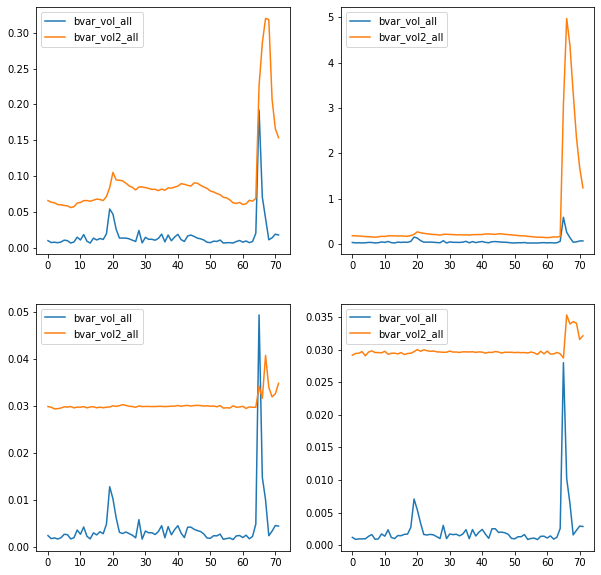

In [55]:
# Create a 2x2 subplots on matplotlib of bvar_vol_all

fig, ax = plt.subplots(2, 2, figsize=(10, 10))
 
# For each subplot, plot bvar_vol_all and bvar_vol2_all for each variable
for i in range(2):
  for j in range(2):
      ax[i, j].plot(bvar_vol_all[:, i*2 + j], label='bvar_vol_all')
      ax[i, j].plot(bvar_vol2_all[:, i*2 + j], label='bvar_vol2_all')
      ax[i, j].legend()

plt.show()


### Quarterly

In [73]:
data = pd.read_csv('SVol Benchmarks/quarterlyData_updated.csv')
data = data[['house_starts', 'unrate', 'GDP', 'inf']]
test_size = 72
window_size = 60

In [74]:
preds_all = np.zeros((test_size, 4))
vol_all = np.zeros((test_size, 4))

In [75]:
for var in range(data.shape[1]):
  for t in range(test_size):
    # Create a training set of size window_size
    y_train = data.iloc[(len(data) - test_size + t - window_size):(len(data) - test_size + t), var]
    # Concat the two lags to get the training set
    Y_train = pd.DataFrame(np.vstack((y_train, y_train.shift(1), y_train.shift(2))).T).dropna()
    Y_train.columns = ['y', 'y_lag1', 'y_lag2']
    X_train = Y_train[['y_lag1', 'y_lag2']]
    y_train = Y_train['y']

    # Run a regression
    # Add constant term
    X_train = sm.add_constant(X_train)
    # Fit the model - use X to predict y
    model = sm.OLS(y_train, X_train).fit()
    # Get the residuals in the training set
    resid_train = model.resid
    # Get the SD of the residuals
    sd_resid = np.std(resid_train)
    # Make predictions 
    X_test = np.array(Y_train.iloc[-1, :2]).reshape(1,-1)
    # Concat a 1 to the end
    X_test = np.hstack((np.ones((1,1)), X_test))
    Y_test_pred = model.predict(X_test)
    
    preds_all[t, var] = Y_test_pred
    vol_all[t, var] = sd_resid

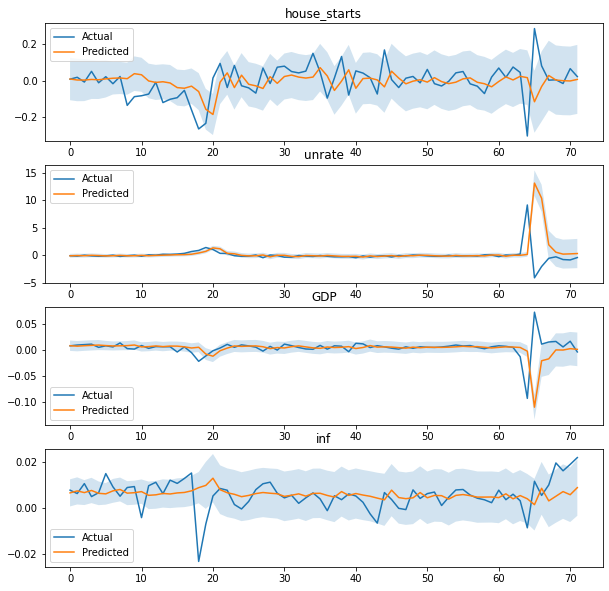

In [76]:
# Plot preds_all
import matplotlib.pyplot as plt
# Each variable on different subplot
fig, axs = plt.subplots(4, 1, figsize=(10, 10))
for var in range(data.shape[1]):
  axs[var].plot(data.iloc[-test_size:, var].reset_index(drop=True), label='Actual')
  axs[var].plot(preds_all[:, var], label='Predicted')
  
  # Draw the 95% confidence interval
  axs[var].fill_between(np.arange(test_size), preds_all[:, var] - 1.96*vol_all[:, var], preds_all[:, var] + 1.96*vol_all[:, var], alpha=0.2)
  
  axs[var].set_title(data.columns[var])
  axs[var].legend()

In [77]:
# Save preds_all and vol_all
np.save('SVol Benchmarks/arfit_all_quarterly_4var_ar2_constvol.npy', preds_all)
np.save('SVol Benchmarks/svfit_all_quarterly_4var_ar2_constvol.npy', vol_all)

### Monthly

In [2]:
#data = pd.read_csv('SVol Benchmarks/monthlyData_updated.csv')
data = pd.read_csv('monthlyData_updated_8var.csv')
data = data[['oil', 'Ex', 'SPY', 'DGS3', 'inf', 'unrate', 'indpro', 'house_starts']]
test_size = 30
window_size = 180

In [11]:
from statsmodels.tsa.api import VAR

max_h = 16
n_var = 8

var_model = VAR(data)
var_results = var_model.fit(2)
irf = var_results.irf(max_h)
irf_median = irf.orth_irfs
irf_stderr = irf.stderr(orth = True)


# (n_horizons, var, var, std errors)
var_irf = np.zeros((max_h + 1, n_var, n_var, 3))
var_irf[:] = np.nan
var_irf[:, :, :, 1] = irf_median
var_irf[:, :, :, 0] = irf_median - 1 * irf_stderr
var_irf[:, :, :, 2] = irf_median + 1 * irf_stderr


irf_cum_median = irf.orth_cum_effects
irf_cum_stderr = irf.cum_effect_stderr(orth = True)
var_cum_irf = np.zeros((max_h + 1, n_var, n_var, 3))
var_cum_irf[:] = np.nan
var_cum_irf[:, :, :, 1] = irf_cum_median
var_cum_irf[:, :, :, 0] = irf_cum_median - 1 * irf_cum_stderr
var_cum_irf[:, :, :, 2] = irf_cum_median + 1 * irf_cum_stderr

# Transpose (2,1,0)
var_irf =  np.transpose(var_irf, (2, 1, 0, 3))
var_cum_irf = np.transpose(var_cum_irf, (2, 1, 0, 3))

In [15]:
shock_var = 1
response_var = 0
var_irf_h = var_cum_irf[shock_var, response_var, 12, 1]
var_irf_h = var_irf_h / var_cum_irf[shock_var, shock_var, 0, 1]

var_irf_h

-0.17881978881204408

In [7]:
preds_all = np.zeros((test_size, 8))
vol_all = np.zeros((test_size, 8))

In [8]:
for var in range(data.shape[1]):
  for t in range(test_size):
    # Create a training set of size window_size
    y_train = data.iloc[(len(data) - test_size + t - window_size):(len(data) - test_size + t), var]
    # Concat the two lags to get the training set
    Y_train = pd.DataFrame(np.vstack((y_train, y_train.shift(1), y_train.shift(2))).T).dropna()
    Y_train.columns = ['y', 'y_lag1', 'y_lag2']
    X_train = Y_train[['y_lag1', 'y_lag2']]
    y_train = Y_train['y']

    # Run a regression
    # Add constant term
    X_train = sm.add_constant(X_train)
    # Fit the model - use X to predict y
    model = sm.OLS(y_train, X_train).fit()
    # Get the residuals in the training set
    resid_train = model.resid
    # Get the SD of the residuals
    sd_resid = np.std(resid_train)
    # Make predictions 
    X_test = np.array(Y_train.iloc[-1, :2]).reshape(1,-1)
    # Concat a 1 to the end
    X_test = np.hstack((np.ones((1,1)), X_test))
    Y_test_pred = model.predict(X_test)
    
    preds_all[t, var] = Y_test_pred
    vol_all[t, var] = sd_resid

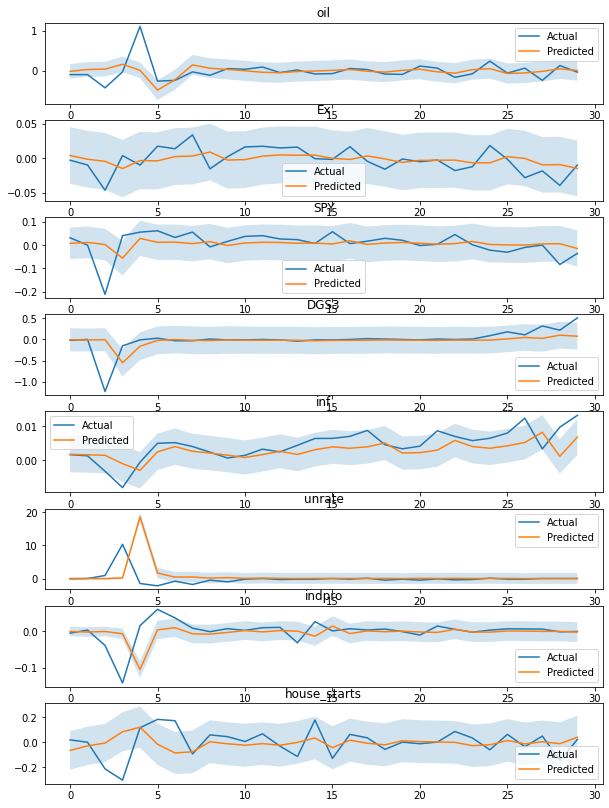

In [10]:
# Plot preds_all
import matplotlib.pyplot as plt
# Each variable on different subplot
fig, axs = plt.subplots(8, 1, figsize=(10, 14))
for var in range(data.shape[1]):
  axs[var].plot(data.iloc[-test_size:, var].reset_index(drop=True), label='Actual')
  axs[var].plot(preds_all[:, var], label='Predicted')
  
  # Draw the 95% confidence interval
  axs[var].fill_between(np.arange(test_size), preds_all[:, var] - 1.96*vol_all[:, var], preds_all[:, var] + 1.96*vol_all[:, var], alpha=0.2)
  
  axs[var].set_title(data.columns[var])
  axs[var].legend()

In [12]:
# Save preds_all and vol_all
np.save('SVol Benchmarks/arfit_all_monthly_8var_till2019_ar2_constvol.npy', preds_all)
np.save('SVol Benchmarks/svfit_all_monthly_8var_till2019_ar2_constvol.npy', vol_all)

### BVAR Benchmark

In [40]:
# Mean predictions
preds_all = pyreadr.read_r(f'SVol Benchmarks/y_pred_all_quarterly_4var_bvar_hor1.RData')['y_pred_hor1'].to_numpy().T
# SD predictions
vol_all = pyreadr.read_r(f'SVol Benchmarks/y_sd_all_quarterly_4var_bvar_hor1.RData')['y_sd_hor1'].to_numpy().T

In [42]:
data = pd.read_csv('SVol Benchmarks/quarterlyData_updated.csv')
data = data[['house_starts', 'unrate', 'GDP', 'inf']]
test_size = 72

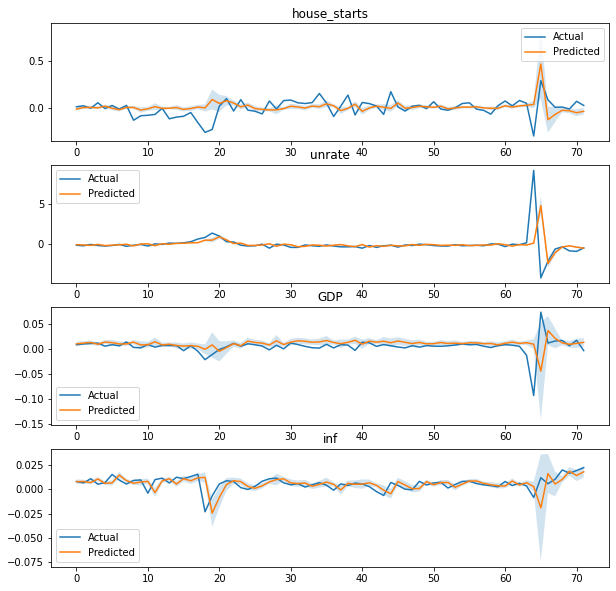

In [43]:
# Plot preds_all
import matplotlib.pyplot as plt
# Each variable on different subplot
fig, axs = plt.subplots(4, 1, figsize=(10, 10))
for var in range(data.shape[1]):
  axs[var].plot(data.iloc[-test_size:, var].reset_index(drop=True), label='Actual')
  axs[var].plot(preds_all[:, var], label='Predicted')
  
  # Draw the 95% confidence interval
  axs[var].fill_between(np.arange(test_size), preds_all[:, var] - 1.96*vol_all[:, var], preds_all[:, var] + 1.96*vol_all[:, var], alpha=0.2)
  
  axs[var].set_title(data.columns[var])
  axs[var].legend()

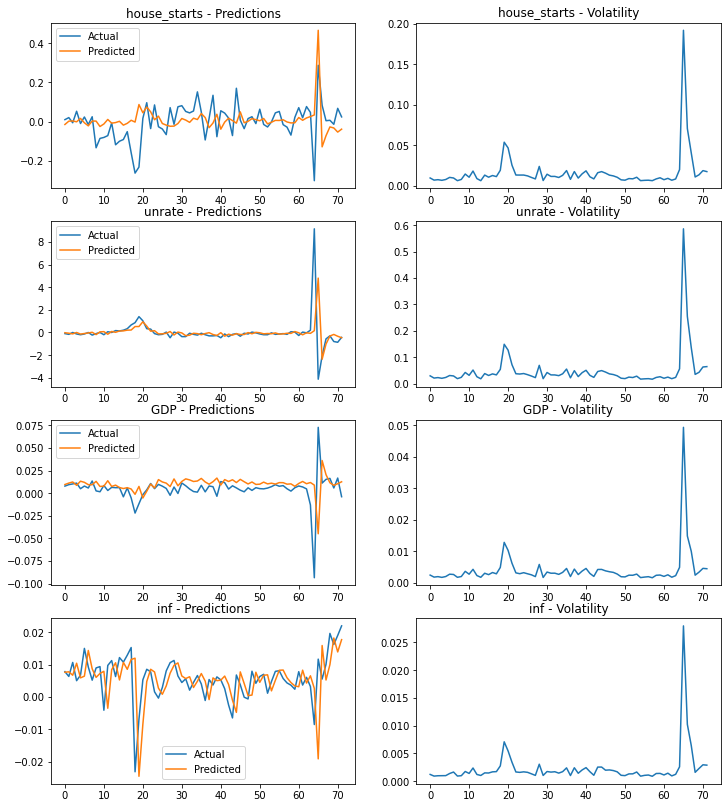

In [49]:
# Plot preds_all
import matplotlib.pyplot as plt
# Each variable on different subplot
fig, axs = plt.subplots(4, 2, figsize=(12, 14))
for var in range(data.shape[1]):
  axs[var,0].plot(data.iloc[-test_size:, var].reset_index(drop=True), label='Actual')
  axs[var,0].plot(preds_all[:, var], label='Predicted')
  
  axs[var,1].plot(vol_all[:, var])
  
  axs[var, 0].set_title(data.columns[var] + ' - Predictions')
  axs[var, 1].set_title(data.columns[var] + ' - Volatility')
  axs[var, 0].legend()

### Checking Dataset Dates

In [2]:
data = pd.read_csv('SVol Benchmarks/quarterlyData_updated.csv')

In [5]:
data.iloc[-11:]

,Unnamed: 0,Date,oil,Ex,SPY,DGS3,GDP,inf,unrate,house_starts
238,238,12/1/2019,-0.063217,-0.041542,0.025918,-0.3200,0.006832,0.003683,0.0333,0.019685
239,239,3/1/2020,0.006945,0.043873,0.042307,-0.4033,0.004680,0.006071,-0.0333,0.076505
240,240,6/1/2020,-0.223173,-0.006542,-0.005570,-0.4667,-0.013122,0.003225,0.2000,0.046650
241,241,9/1/2020,-0.496939,-0.030462,-0.046873,-0.9667,-0.093621,-0.008542,9.1667,-0.301534
242,242,12/1/2020,0.377745,0.040645,0.125875,-0.0300,0.072763,0.011707,-4.1334,0.287145
243,243,3/1/2021,0.034238,0.020970,0.067716,-0.0200,0.011091,0.005540,-2.0666,0.082746
244,244,6/1/2021,0.301790,0.043424,0.083164,-0.0433,0.015222,0.010090,-0.5667,0.004437
245,245,9/1/2021,0.119256,0.014042,0.079580,-0.0233,0.016274,0.019673,-0.3000,0.006515
246,246,12/1/2021,0.055409,-0.014840,0.055490,0.0200,0.005693,0.016250,-0.8000,-0.013921
247,247,3/1/2022,0.080207,-0.021271,0.039864,0.0066,0.016668,0.019037,-0.8667,0.067547


In [4]:
data = pd.read_csv('data/quarterlyData_updated.csv')
dates = data['Unnamed: 0']

In [5]:
# Create a list of dates, starting with 1st June 1960, ending with 1st June 2022, and with a frequency of quarterly
date_list = pd.date_range(start='1960-06-01', end='2022-07-01', freq='Q')

# Recession dates
recession_dates = [
  ['1960-04-01', '1961-02-01'],
  ['1969-12-01', '1970-11-01'],
  ['1973-11-01', '1975-03-01'],
  ['1980-01-01', '1980-07-01'],
  ['1981-07-01', '1982-11-01'],
  ['1990-07-01', '1991-03-01'],
  ['2001-03-01', '2001-11-01'],
  ['2007-12-01', '2009-06-01'],
  ['2020-02-01', '2020-04-01']
]

# Generate random 249 numbers between 0 and 1
time_series =  np.random.rand(249)

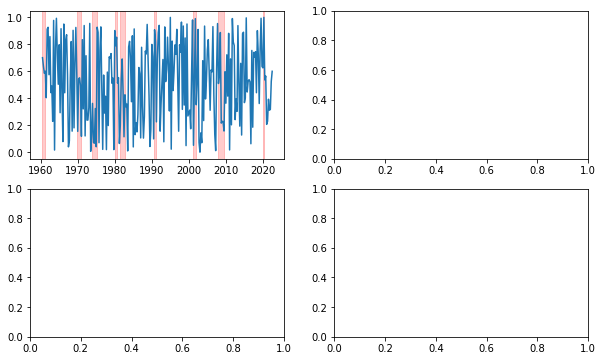

In [68]:
# Plot the time series using matplotlib, with dates on the x-axis. Highlight the recession periods
fig, ax = plt.subplots(2, 2, figsize=(10, 6))
ax[0,0].plot(date_list, time_series)
for i in range(len(recession_dates)):
  ax[0,0].axvspan(recession_dates[i][0], recession_dates[i][1], alpha=0.2, color='red')

In [6]:
date_list = pd.date_range(start='1960-06-01', end='2022-07-01', freq='Q')

In [52]:
date_list = pd.date_range(start='1960-03-01', end='2022-08-01', freq='M')

In [7]:
import matplotlib.pyplot as plt
import numpy as np

In [8]:
plt.cm.coolwarm(np.linspace(0, 1, 6))

array([[0.2298057 , 0.29871797, 0.75368315, 1.        ],
       [0.48385433, 0.62204985, 0.9748082 , 1.        ],
       [0.75361062, 0.83023285, 0.96087116, 1.        ],
       [0.9473454 , 0.7946955 , 0.71699051, 1.        ],
       [0.9318313 , 0.51908552, 0.40647961, 1.        ],
       [0.70567316, 0.01555616, 0.15023281, 1.        ]])